In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 13.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 15837 (delta 35), reused 14 (delta 14), pack-reused 15772 (from 2)
Receiving objects: 100% (15837/15837), 6.41 MiB | 9.30 MiB/s, done.
Resolving deltas: 100% (11533/11533), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your e

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="mPBU1v94SGezxUf85k53")
project = rf.workspace("marcus-vinicius-kep9s").project("01000100yolo-redux")
version = project.version(1)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to 01000100YOLO-Redux-1 in coco:: 100%|██████████| 5057/5057 [00:01<00:00, 5008.97it/s]


In [5]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_train", {}, "/kaggle/working/01000100YOLO-Redux-1/train/_annotations.coco.json", "/kaggle/working/01000100YOLO-Redux-1/train")
register_coco_instances("my_dataset_val", {}, "/kaggle/working/01000100YOLO-Redux-1/valid/_annotations.coco.json", "/kaggle/working/01000100YOLO-Redux-1/valid")
register_coco_instances("my_dataset_test", {}, "/kaggle/working/01000100YOLO-Redux-1/test/_annotations.coco.json", "/kaggle/working/01000100YOLO-Redux-1/test")

WARNING [03/19 17:47:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/19 17:47:22 d2.data.datasets.coco]: Loaded 3529 images in COCO format from /kaggle/working/01000100YOLO-Redux-1/train/_annotations.coco.json


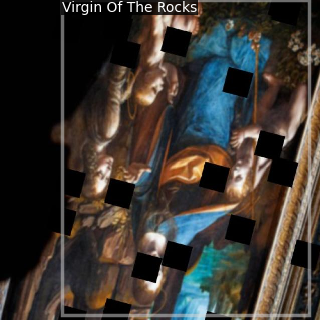

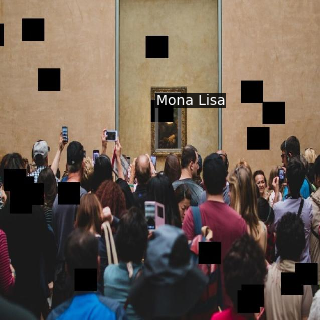

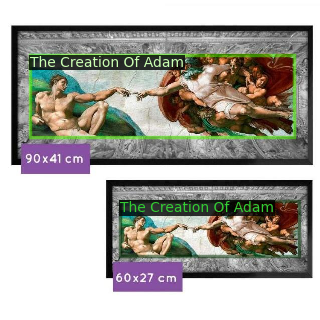

In [6]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [7]:
import os
import numpy as np
import torch
import time
import datetime
import logging
from detectron2.engine import HookBase, DefaultTrainer
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.logger import log_every_n_seconds
import detectron2.utils.comm as comm
from detectron2.config import get_cfg
from detectron2 import model_zoo

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
        
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    f"Loss on Validation done {idx + 1}/{total}. {seconds_per_img:.4f} s / img. ETA={eta}",
                    n=5,
                )
            
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()
    
    def _get_loss(self, data):
        metrics_dict = self._model(data)
        metrics_dict = {k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v) for k, v in metrics_dict.items()}
        return sum(metrics_dict.values())
    
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
    
    def build_hooks(self):
        hooks = super().build_hooks()
        if len(self.cfg.DATASETS.VAL) > 0:  # Garante que haja um dataset de validação
            hooks.insert(-1, LossEvalHook(
                self.cfg.TEST.EVAL_PERIOD,
                self.model,
                build_detection_test_loader(
                    self.cfg,
                    self.cfg.DATASETS.VAL[0],
                    DatasetMapper(self.cfg, True)
                )
            ))
        return hooks

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.VAL = ("my_dataset_val",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
# Parte do Retinanet
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Teste com valores entre 0.4 e 0.6
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3  # Teste com valores entre 0.3 e 0.5
# Acaba aqui
cfg.TEST.EVAL_PERIOD = 100
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/19 17:47:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:07, 22.2MB/s]                              


[03/19 17:47:41 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


[03/19 17:48:00 d2.utils.events]:  eta: 0:27:18  iter: 19  total_loss: 1.854  loss_cls: 1.699  loss_box_reg: 0.08575  loss_rpn_cls: 0.02163  loss_rpn_loc: 0.01034    time: 0.8146  last_time: 0.8247  data_time: 0.0582  last_data_time: 0.0379   lr: 0.00039962  max_mem: 5720M
[03/19 17:48:29 d2.utils.events]:  eta: 0:27:14  iter: 39  total_loss: 0.3231  loss_cls: 0.1975  loss_box_reg: 0.09826  loss_rpn_cls: 0.0089  loss_rpn_loc: 0.009515    time: 0.8222  last_time: 0.8686  data_time: 0.0536  last_data_time: 0.0548   lr: 0.00079922  max_mem: 5720M
[03/19 17:48:46 d2.utils.events]:  eta: 0:27:15  iter: 59  total_loss: 0.2461  loss_cls: 0.1299  loss_box_reg: 0.1054  loss_rpn_cls: 0.004849  loss_rpn_loc: 0.008276    time: 0.8309  last_time: 0.8592  data_time: 0.0532  last_data_time: 0.0527   lr: 0.0011988  max_mem: 5720M
[03/19 17:49:03 d2.utils.events]:  eta: 0:27:06  iter: 79  total_loss: 0.2282  loss_cls: 0.1093  loss_box_reg: 0.1007  loss_rpn_cls: 0.006194  loss_rpn_loc: 0.00774    time: 

In [8]:
#register_coco_instances("my_dataset_test", {}, "/kaggle/working/01000100YOLO-5/test/_annotations.coco.json", "/kaggle/working/01000100YOLO-5/test")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_test", )
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

[03/19 18:35:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


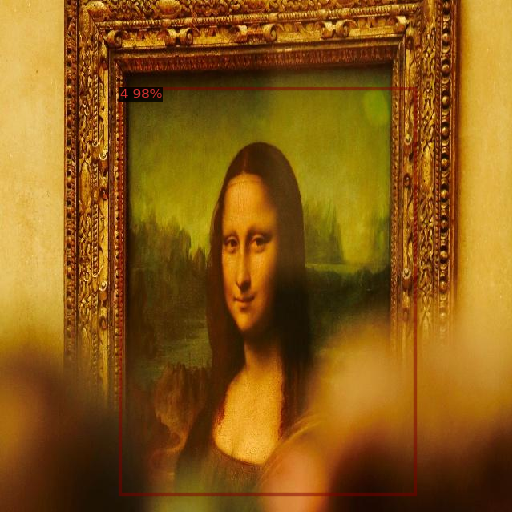

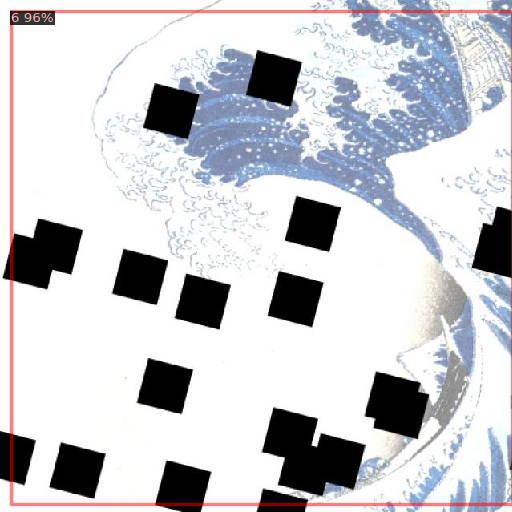

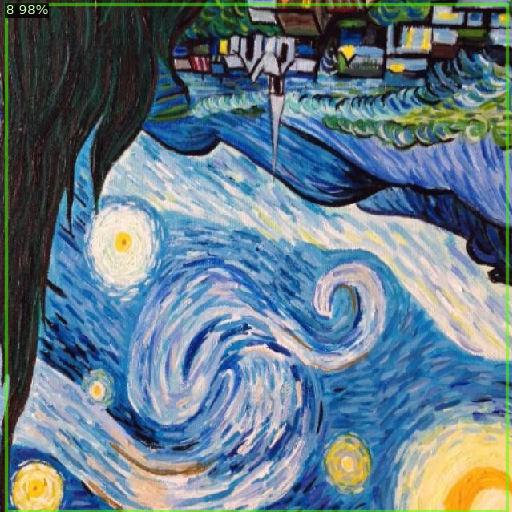

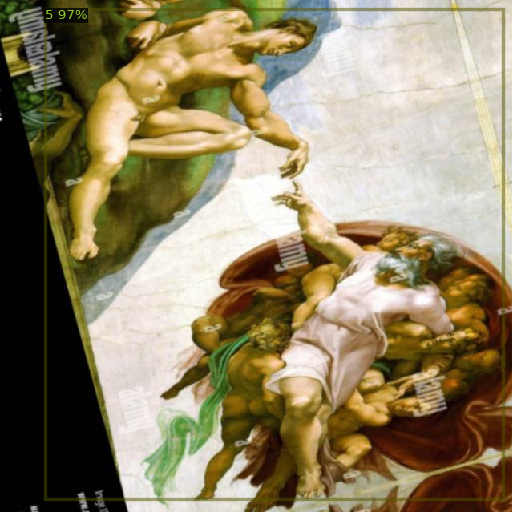

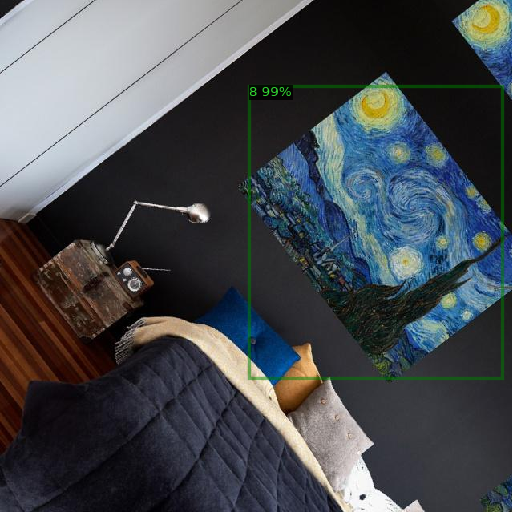

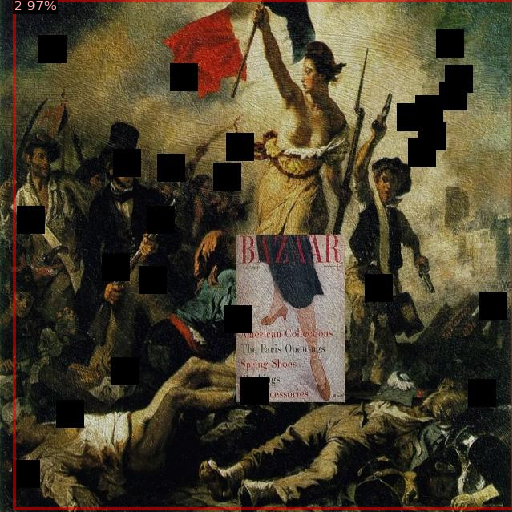

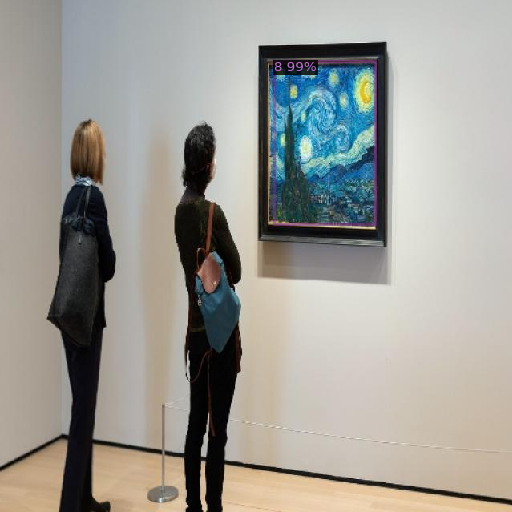

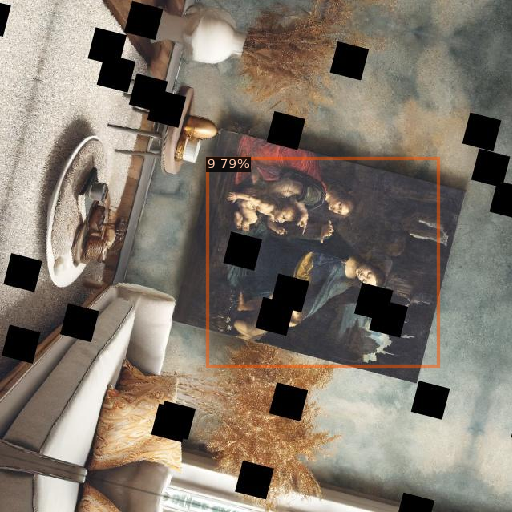

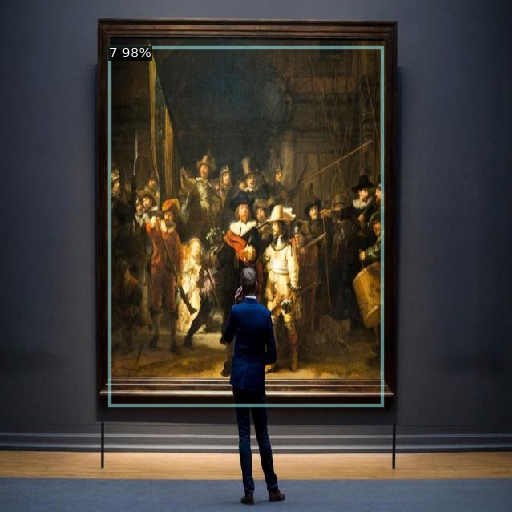

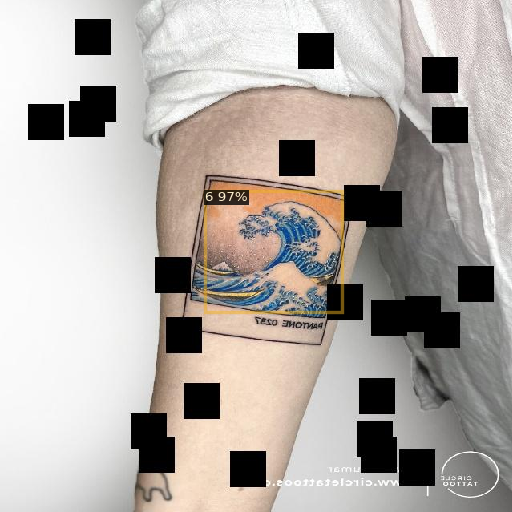

In [9]:
from detectron2.utils.visualizer import ColorMode
import glob
import random

N = 10  # Número de imagens desejadas
image_paths = random.sample(glob.glob('/kaggle/working/01000100YOLO-Redux-1/test/*jpg'), N)

for imageName in image_paths:
    im = cv2.imread(imageName)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.8
                  )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


# **Validação**

In [10]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_test", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[03/19 18:35:37 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [03/19 18:35:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/19 18:35:37 d2.data.datasets.coco]: Loaded 750 images in COCO format from /kaggle/working/01000100YOLO-Redux-1/test/_annotations.coco.json
[03/19 18:35:37 d2.data.build]: Distribution of instances among all 10 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| painting-JuhU | 0            | Les Noces d.. | 71           | Liberty Lea.. | 79           |
| Meisje met .. | 102          |   Mona Lisa   | 79           | The Creatio.. | 85           |
| The Great W.. | 93           | The Night W.. | 89           | The Starry .. | 75           |
| Virgin Of T.. | 85           |               |

# **Baixar modelo**

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/arquivo", 'zip', "/kaggle/working/output")

#from google.colab import files
#files.download("/kaggle/working/outputarquivo.zip")